In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import AUTOTUNE

import imagepairs

In [2]:
def random_crop(ds, hr_crop_size=96, scale=2):
    lr_img = ds['image']
    hr_img = ds['image_gt']
    
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

def get_patches(ds_train, patch_size=96):
    batch_size = 1
    repeat_count = None
    ds = ds_train.map(lambda ds: random_crop(ds, patch_size), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.repeat(repeat_count)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [3]:
import matplotlib.pyplot as plt

def plot_sample(lr, hr, titles=['LR', 'HR']):
    plt.figure(figsize=(20, 10))

    images = [lr, hr]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [4]:
from tensorflow.keras.layers import Conv2D, Input, ReLU, Lambda, Add
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_normal
import tensorflow.keras.backend as K

def abpn(scale=3, in_channels=3, num_fea=28, m=4, out_channels=3):
    inp = Input(shape=(None, None, 3)) 
    upsample_func = Lambda(lambda x_list: tf.concat(x_list, axis=3))
    upsampled_inp = upsample_func([inp for x in range(scale**2)])

    # Feature extraction
    x = Conv2D(num_fea, 3, padding='same', activation='relu', kernel_initializer=glorot_normal(), bias_initializer='zeros')(inp)

    for i in range(m):
        x = Conv2D(num_fea, 3, padding='same', activation='relu', kernel_initializer=glorot_normal(), bias_initializer='zeros')(x)

    # Pixel-Shuffle
    x = Conv2D(out_channels*(scale**2), 3, padding='same', activation='relu', kernel_initializer=glorot_normal(), bias_initializer='zeros')(x)
    x = Conv2D(out_channels*(scale**2), 3, padding='same', kernel_initializer=glorot_normal(), bias_initializer='zeros')(x)
    x = Add()([upsampled_inp, x])
    
    depth_to_space = Lambda(lambda x: tf.nn.depth_to_space(x, scale))
    out = depth_to_space(x)
    clip_func = Lambda(lambda x: K.clip(x, 0., 255.))
    out = clip_func(out)
    
    return Model(inputs=inp, outputs=out, name='abpn')

In [5]:
model_abpn = abpn(2) # ABPN super resolution scale = 2
model_abpn.load_weights('models/checkpoint/abpn_x2_ip/checkpoint').expect_partial()

In [6]:
model_path = '/tmp/edsr_imagepairs/exports/edsr_f28b5/saved_model'
imported = tf.saved_model.load(model_path)
model_edsr_f28 = imported.signatures["serving_default"]

In [7]:
model_path = '/tmp/edsr_imagepairs/exports/edsr_f64b16/saved_model'
imported = tf.saved_model.load(model_path)
model_edsr_f64 = imported.signatures["serving_default"]

In [8]:
from PIL import Image

In [9]:
lr_image = Image.open('demo/ip_test_0003_cropped_lr.png')
hr_image = Image.open('demo/ip_test_0003_cropped_hr.png')

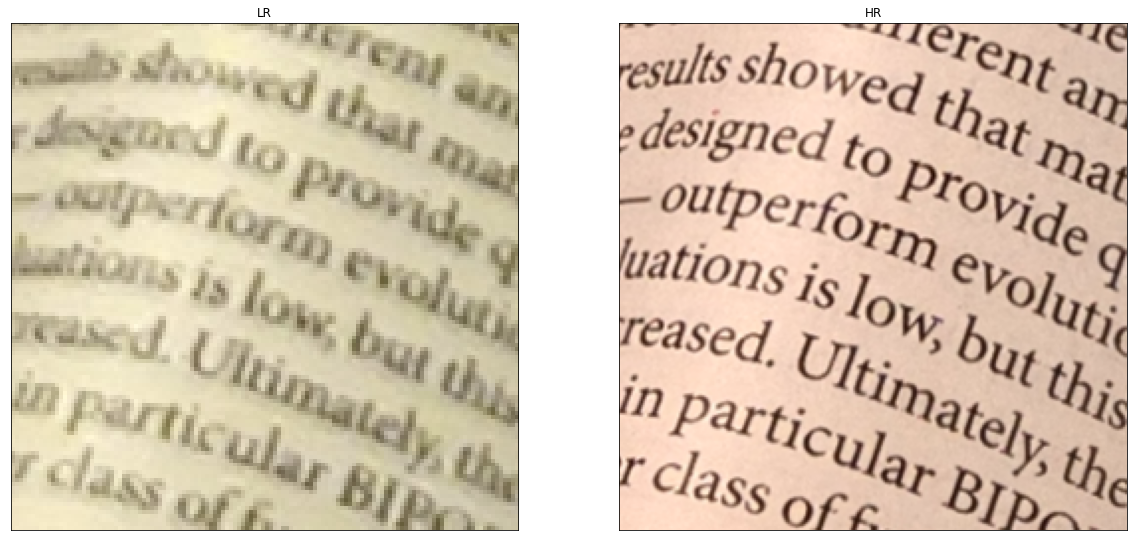

In [10]:
plot_sample(lr_image, hr_image)

In [11]:
lr_np = tf.expand_dims(np.array(lr_image), 0)
hr_np = tf.expand_dims(np.array(hr_image), 0)

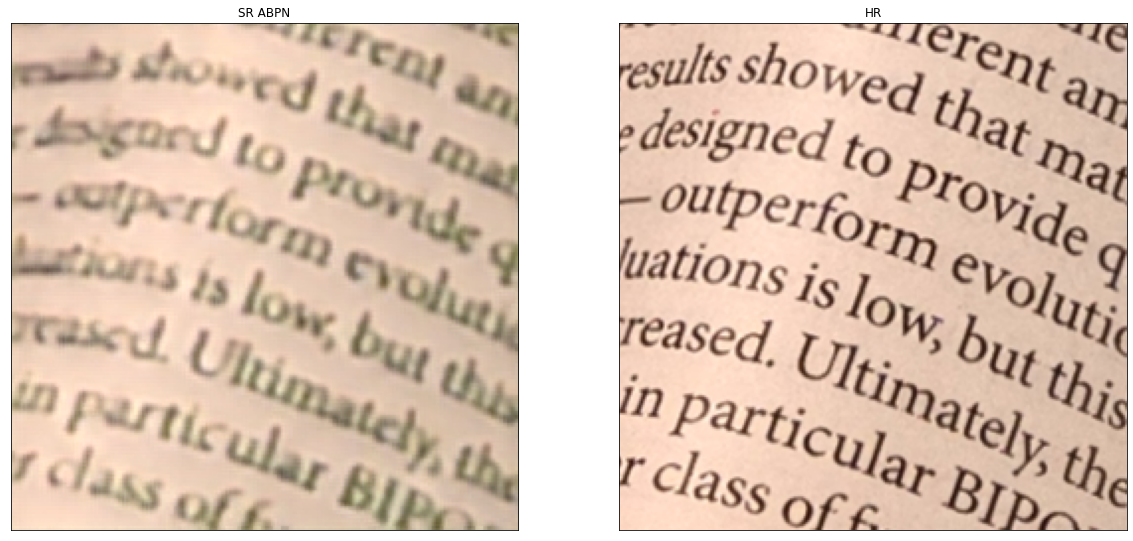

In [12]:
sr_abpn = tf.cast(model_abpn(lr_np), tf.uint8)
plot_sample(tf.squeeze(sr_abpn).numpy(), tf.squeeze(hr_np).numpy(), ('SR ABPN', 'HR'))

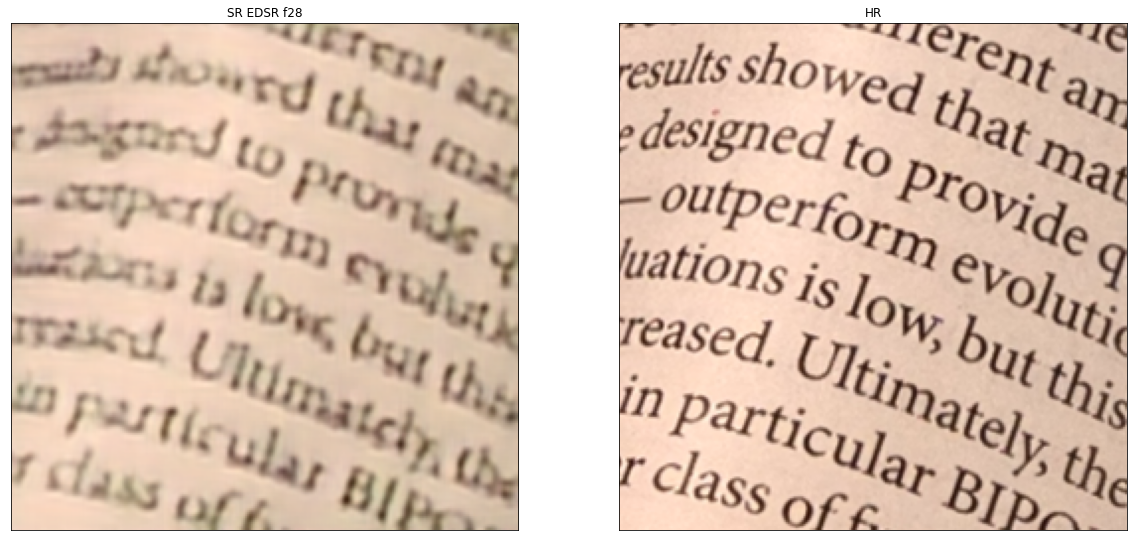

In [13]:
sr_edsr_f28 = tf.cast(tf.clip_by_value(model_edsr_f28(tf.cast(lr_np, tf.float32))['lambda_2'], 0, 255.0), tf.uint8)
plot_sample(tf.squeeze(sr_edsr_f28).numpy(), tf.squeeze(hr_np).numpy(), ('SR EDSR f28', 'HR'))

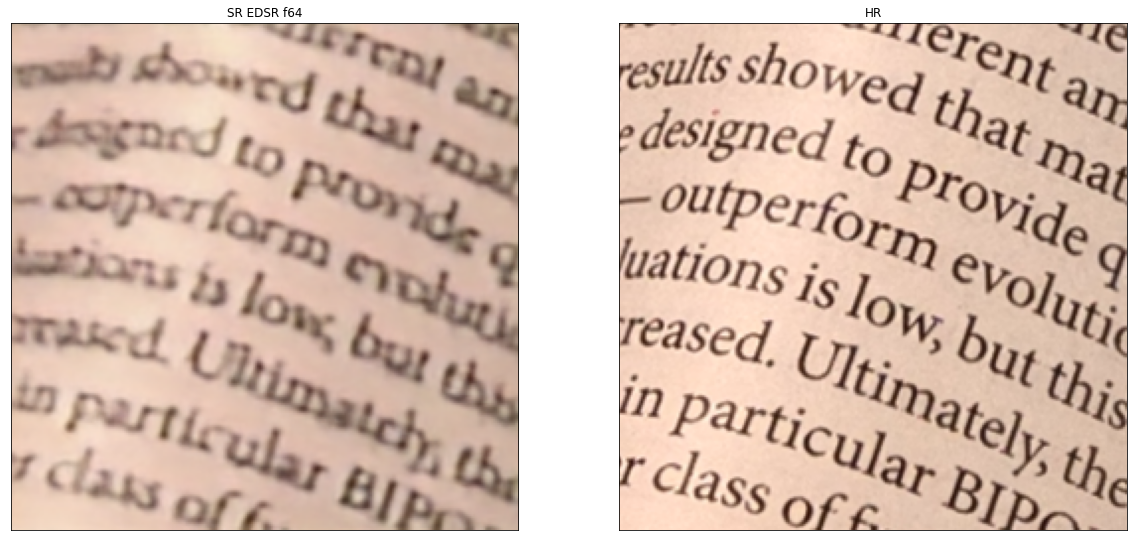

In [14]:
sr_edsr_f64 = tf.cast(tf.clip_by_value(model_edsr_f64(tf.cast(lr_np, tf.float32))['lambda_2'], 0, 255.0), tf.uint8)
plot_sample(tf.squeeze(sr_edsr_f64).numpy(), tf.squeeze(hr_np).numpy(), ('SR EDSR f64', 'HR'))

In [15]:
psnr_abpn = tf.image.psnr(sr_abpn, hr_np, 255).numpy()[0]
psnr_edsr_f28 = tf.image.psnr(sr_edsr_f28, hr_np, 255).numpy()[0]
psnr_edsr_f64 = tf.image.psnr(sr_edsr_f64, hr_np, 255).numpy()[0]
print(f'PSNR of (abpn, edsr_f28, edsr_f64): ({psnr_abpn}, {psnr_edsr_f28}, {psnr_edsr_f64})')

ssim_abpn = tf.image.ssim(sr_abpn, hr_np, 255).numpy()[0]
ssim_edsr_f28 = tf.image.ssim(sr_edsr_f28, hr_np, 255).numpy()[0]
ssim_edsr_f64 = tf.image.ssim(sr_edsr_f64, hr_np, 255).numpy()[0]
print(f'SSIM of (abpn, edsr_f28, edsr_f64): ({ssim_abpn}, {ssim_edsr_f28}, {ssim_edsr_f64})')

PSNR of (abpn, edsr_f28, edsr_f64): (17.28076171875, 17.826074600219727, 17.593097686767578)
SSIM of (abpn, edsr_f28, edsr_f64): (0.5458542704582214, 0.6114697456359863, 0.604569137096405)
